# Progetto "Filtro Anti-Hater per Social Network"
### Progetto Finale del corso "Deep Learning e Reti Neurali Artificiali"


Il progetto finale del corso consiste nella creazione di un modello di deep learning in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:

Gli step che saranno seguiti:
* Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
* Trasformare il corpus testuale in sequenze
* Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel

In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic, severe_toxic, obscene, threat, insult, identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.




## Esplorazione dei Dati

Iniziamo con un'esplorazione dei dati. Leggiamo il dataset con pandas e vediamo alcuner caratteristiche dei dati

In [68]:
#Importiamo librerie per EDA

import pandas as pd
import seaborn as sns

In [69]:
# Leggiamo con pandas il csv per importare il dataset
df = pd.read_csv("Filter_Toxic_Comments_dataset.csv")
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


Il dataset è costituito da 8 colonne : la prima con il testo dei commenti, 6 colonne definiscono il grado di tossicità o di insulto e infine, l'ultima colonna ci identifica la somma delle 6 precedenti

In [70]:
for col in range(1,8):
    print(f"Numbero di commenti nella classe '{df.columns[col]}': {sum(df.iloc[:,col]==1)}")


print(f"Numbero di commenti con multi classe : {sum(df.sum_injurious>=2)}")

Numbero di commenti nella classe 'toxic': 15294
Numbero di commenti nella classe 'severe_toxic': 1595
Numbero di commenti nella classe 'obscene': 8449
Numbero di commenti nella classe 'threat': 478
Numbero di commenti nella classe 'insult': 7877
Numbero di commenti nella classe 'identity_hate': 1405
Numbero di commenti nella classe 'sum_injurious': 6360
Numbero di commenti con multi classe : 9865


Vediamo come sono distribuiti i valori nella colonna `sum_injurious`

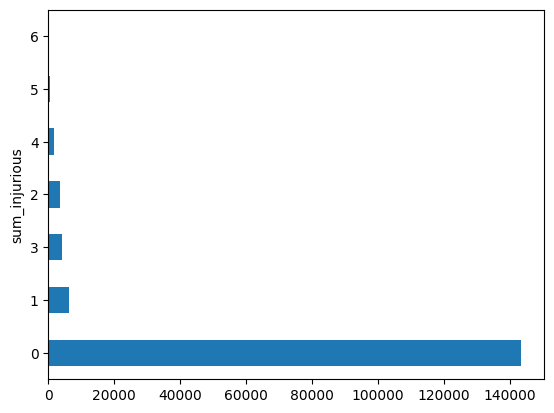

In [71]:

ax = df.sum_injurious.value_counts().plot(kind='barh')


Vediamo subito che i commenti negativi sono molto pochi rispetto al totale dei commenti. Dovremo sicuramente tenerne conto durante la fase di addestramento del modello

Vediamo ora la lunghezza dei commenti. La lunghezza media dei 

Lunghezza mediana dei commenti: 205.0
Lunghezza minima dei commenti: 6
Lunghezza massima dei commenti: 5000


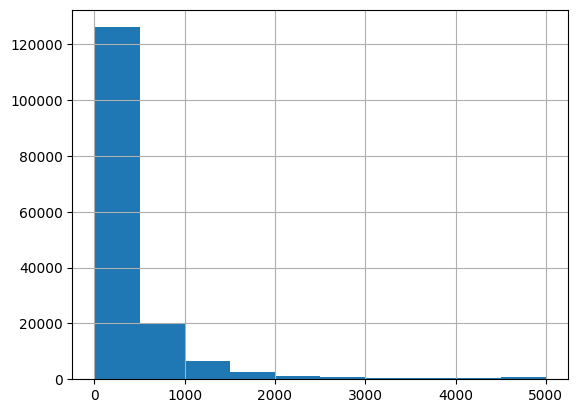

In [72]:
df.comment_text.apply(lambda comment: len(comment)).hist()

print(f'Lunghezza mediana dei commenti: {df.comment_text.apply(lambda comment: len(comment)).median()}')
print(f'Lunghezza minima dei commenti: {df.comment_text.apply(lambda comment: len(comment)).min()}')
print(f'Lunghezza massima dei commenti: {df.comment_text.apply(lambda comment: len(comment)).max()}')

## Processamento del testo

In [73]:
# Importiamo le librerie per il processamento dei dati
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lorenzodemarco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Utilizziamo due librerie keras e nltk per pulire i dati. Nello specifico vogliamo togliere le stop_words e la punteggiatura. Inoltre trasformiamo tutto in lower case. 
Facciamo un esempio prima di applicare questi step al nostro dataset

In [74]:
# Visto che i nostri commenti sono in inglese scarichiamo le stop words inglesi
stop_words = set(stopwords.words('english'))

text = "The cat is on the bed "

# Passiamo alla tokenizzazione. In questa fase, la frase è scomposta parola per parola
words= word_tokenize(text)

# Rimozione delle stopwords e trasformiamo tutto in lower case
words_no_stopwords = [word.lower() for word in words if word.lower() not in stop_words]

# Riformiamo la frase senza le stop word
text_no_stopwords = ' '.join(words_no_stopwords)


tokenizer = Tokenizer()
tokenizer.fit_on_texts([text_no_stopwords])


sequenze = tokenizer.texts_to_sequences([text_no_stopwords])

# # Padding delle sequenze. Settiamo un numero casuale di lunghezza massima.
max_len = 10
padded_sequences = pad_sequences(sequenze, maxlen=max_len)
print(padded_sequences)

[[0 0 0 0 0 0 0 0 1 2]]


Proviamo ora ad applicare lo stesso processo a tutto il dataset. Definiamo una funzione che esegue tutti i passaggi di preprocessing appena visti

In [75]:
def preprocessing_text(comment):
    stop_words = set(stopwords.words('english'))
    words= word_tokenize(comment)
    words_no_stopwords = [word.lower() for word in words if word.lower() not in stop_words]
    text_no_stopwords = ' '.join(words_no_stopwords)
    return text_no_stopwords


Applichiamo ora la funzione al dataset con apply e definiamo una nuova colonna

In [76]:
df['preprocessed_text'] = df['comment_text'].apply(preprocessing_text)

In [77]:
# 
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,preprocessed_text
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,d'aww ! matches background colour 'm seemingly...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,"hey man , 'm really trying edit war . 's guy c..."
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,`` ca n't make real suggestions improvement - ...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,", sir , hero . chance remember page 's ?"


Abbiamo ancora qualche problema. Molti messaggi contengono la punteggiatura. Rieseguiamo il preprocessing cercando di rimuoverla.

In [78]:
stop_words = set(stopwords.words('english'))
def preprocessing_text2(comment,stop_words):
    
    comment=comment.translate(str.maketrans('', '', string.punctuation))
    
    words= word_tokenize(comment)
    words_no_stopwords = [word.lower() for word in words if word.lower() not in stop_words ]
    text_no_stopwords = ' '.join(words_no_stopwords)
    return text_no_stopwords





In [79]:
df['preprocessed_text'] = df['comment_text'].apply(lambda x: preprocessing_text2(x,stop_words))

In [80]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,preprocessed_text
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,daww matches background colour im seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,sir hero chance remember page thats


# Divisione del dataset e valutazione di alcuni modelli

Dividiamo il dataset in train e test e iniziamo a vedere come si comportano alcuni modelli

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X=df["preprocessed_text"].values
y=df[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(143613,)
(15958,)
(143613, 6)
(15958, 6)


### Dataset sbilanciato

Un primo problema che riscontriamo nel nostro dataset è sbilanciamento tra le classi. Moltissimi commenti infatti non sono considerati tossici o violenti e quindi hanno la sum_injuries uguale a 0.  
Proviamo a bilanciare il dataset di train


In [83]:
from sklearn.utils import shuffle
df = shuffle(df)
# Dividivamo in train e test il nostro dataset

train_pct_index = int(0.9* df.shape[0])

print(train_pct_index)
df_train, df_test = df[:train_pct_index], df[train_pct_index:]

print(df_train.shape)
print(df_test.shape)
df_train_0=df_train[df_train.sum_injurious==0]
df_train_1=df_train[df_train.sum_injurious>=1]

df_class_0_under = df_train_0.sample(df_train_1.shape[0])

df_train_resampled = pd.concat([df_class_0_under, df_train_1], axis=0)


X_train=df_train_resampled["preprocessed_text"].values
y_train=df_train_resampled[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values
X_test=df_test["preprocessed_text"].values
y_test=df_test[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]]



143613
(143613, 9)
(15958, 9)


Iniziamo valutando alcuni modelli per vedere quale performa meglio sul nostro dataset

In [84]:

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier



logistic_model = Pipeline([
    ("cv",CountVectorizer(stop_words="english", max_features=10000)),
    ("Moc",MultiOutputClassifier(LogisticRegression(max_iter=1000)))]
)
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)


print(classification_report(y_test, y_pred))

/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

              precision    recall  f1-score   support

           0       0.55      0.85      0.67      1490
           1       0.54      0.24      0.33       153
           2       0.78      0.71      0.75       831
           3       0.39      0.20      0.26        46
           4       0.58      0.56      0.57       773
           5       0.38      0.20      0.26       143

   micro avg       0.60      0.69      0.64      3436
   macro avg       0.54      0.46      0.47      3436
weighted avg       0.60      0.69      0.63      3436
 samples avg       0.07      0.07      0.07      3436



/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Osservando il classification report, vediamo che ci sono molte discrepanze. L'accuracy è molto alta solo per le classi con molti esempi, questo ci fa intuire che un primo problema sono le classi sbilanciate. Proviamo a bilanciare le classi assegnando un peso. Dopo proviamo anche a utilizzare SGDClassifier come suggerito dalla documentazione

In [85]:
labels_relative_frequencies = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate']].sum() / len(df)


class_weights = {i: val for i, val in enumerate(1 / labels_relative_frequencies)}
class_weights

{0: 10.433568719759382,
 1: 100.04451410658307,
 2: 18.886377086045687,
 3: 333.8305439330544,
 4: 20.257839278913295,
 5: 113.57366548042704}

In [86]:
logistic_model = Pipeline([
    ("cv",CountVectorizer(stop_words="english", max_features=10000)),
    ("Moc",MultiOutputClassifier(LogisticRegression(class_weight=class_weights,max_iter=4000)))]
)
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)


print(classification_report(y_test, y_pred))


/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

              precision    recall  f1-score   support

           0       0.31      0.89      0.46      1490
           1       0.19      0.60      0.29       153
           2       0.31      0.81      0.45       831
           3       0.19      0.50      0.27        46
           4       0.20      0.74      0.31       773
           5       0.09      0.42      0.15       143

   micro avg       0.26      0.80      0.39      3436
   macro avg       0.22      0.66      0.32      3436
weighted avg       0.27      0.80      0.40      3436
 samples avg       0.07      0.08      0.07      3436



/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
from sklearn.linear_model import SGDClassifier

logistic_model = Pipeline([
    ("cv",CountVectorizer(stop_words="english", max_features=10000)),
    ("Moc",MultiOutputClassifier(SGDClassifier(class_weight=class_weights,max_iter=100,penalty="elasticnet")))]
)
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.27      0.91      0.41      1490
           1       0.38      0.63      0.47       153
           2       0.30      0.85      0.44       831
           3       0.16      0.59      0.25        46
           4       0.25      0.81      0.38       773
           5       0.12      0.56      0.20       143

   micro avg       0.26      0.84      0.40      3436
   macro avg       0.25      0.72      0.36      3436
weighted avg       0.27      0.84      0.41      3436
 samples avg       0.07      0.08      0.07      3436



/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Il modello non sembra migliorare. Proviamo a utilizzare un altro modello.

In [88]:
from sklearn.ensemble  import RandomForestClassifier
randomforest_model = Pipeline([
    ("cv",CountVectorizer(stop_words="english", max_features=10000)),
    ("RF",MultiOutputClassifier(RandomForestClassifier()))]
)
randomforest_model.fit(X_train, y_train)

y_pred = randomforest_model.predict(X_test)


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.54      0.81      0.65      1490
           1       0.51      0.18      0.27       153
           2       0.77      0.77      0.77       831
           3       0.41      0.26      0.32        46
           4       0.64      0.64      0.64       773
           5       0.39      0.26      0.31       143

   micro avg       0.60      0.71      0.65      3436
   macro avg       0.54      0.49      0.49      3436
weighted avg       0.61      0.71      0.64      3436
 samples avg       0.07      0.07      0.07      3436



/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Le performance (precision e recall) sono leggermente migliorate ma c'è sempre un problema per le classi con pochi esempi

Prima di provare ad addestrare una rete RNN, proviamo un ultimo modello.

In [89]:
from sklearn.naive_bayes import BernoulliNB
nb_model = Pipeline([
    ("cv",CountVectorizer(stop_words="english", max_features=10000)),
    ("RF",MultiOutputClassifier(BernoulliNB()))]
)
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.18      0.91      0.29      1490
           1       0.24      0.86      0.37       153
           2       0.13      0.88      0.23       831
           3       0.00      0.02      0.01        46
           4       0.12      0.86      0.22       773
           5       0.24      0.41      0.30       143

   micro avg       0.15      0.85      0.25      3436
   macro avg       0.15      0.65      0.24      3436
weighted avg       0.16      0.85      0.26      3436
 samples avg       0.06      0.08      0.06      3436



/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## RNN : Modello per la classificazione dei commenti

Iniziamo la creazione della rete neurale RNN. Per prima cosa splittiamo il dataset in train e test


In [90]:
# Eseguiamo una prima volta
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(f"Lunghezza : {len(tokenizer.word_counts)}")

vocabulary_size=len(tokenizer.word_index)+1
# Avremo un vocabulary size di 2533002 parole

Lunghezza : 74092


In [91]:
# Decidiamo di tenere le prime 20 mila parole
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)



train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
vocabulary_size=len(tokenizer.word_index)+1

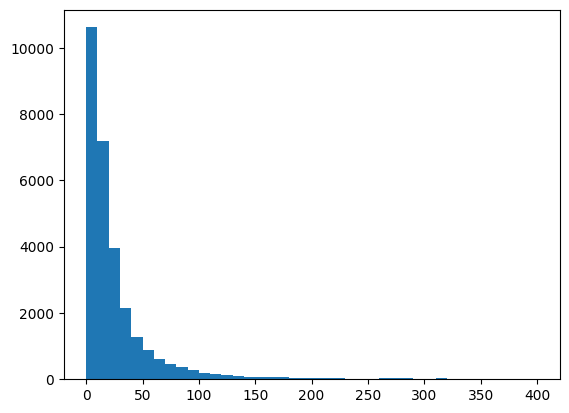

In [92]:

# Per la max len osserviamo i dati 
import matplotlib.pyplot as plt
total_len_distribution = [len(comment) for comment in train_sequences]
plt.hist(total_len_distribution,bins = np.arange(0,410,10))
plt.show()

In [93]:
# Eseguiamo il padding 
# Scegliamo un valore di 200 
max_len=200

padded_train_sequences = pad_sequences(train_sequences, maxlen=max_len)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_len)

# Costruzione del modello

In [94]:

# Secondo Modello
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import Bidirectional,GRU,concatenate,SpatialDropout1D
from keras.layers import GlobalMaxPooling1D,GlobalAveragePooling1D,Conv1D
from keras.models import Model
from keras.layers  import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers  import Concatenate
import matplotlib.pyplot as plt
from keras import layers
from keras.optimizers import Adam,SGD,RMSprop

keras.backend.clear_session()

model = Sequential()
model.add(Embedding(vocabulary_size,100, input_shape=(max_len,)
  ))
model.add(SpatialDropout1D(0.2))

model.add(Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform"))

model.add(Bidirectional(LSTM(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1)))

model.add(GlobalAveragePooling1D())

model.add(Dense(128, activation='relu'))

model.add(Dense(6, activation="sigmoid"))
model.compile(loss='binary_crossentropy',optimizer=RMSprop(epsilon=1e-3),metrics=['accuracy'])
print(model.summary())

/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     7,409,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 200, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 198, 64)        │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 198, 256)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,659,866 (29.22 MB)

 Trainable params: 7,659,866 (29.22 MB)

 Non-trainable params: 0 (0.00 B)

None


In [95]:
batch_size = 128
history=model.fit(padded_train_sequences,y_train, batch_size=batch_size, epochs=5 )

Epoch 1/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 89s 381ms/step - accuracy: 0.8292 - loss: 0.5866
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 93s 407ms/step - accuracy: 0.9718 - loss: 0.3798
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 94s 411ms/step - accuracy: 0.9705 - loss: 0.3822
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 92s 401ms/step - accuracy: 0.9697 - loss: 0.3822
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 100s 435ms/step - accuracy: 0.9718 - loss: 0.3769


In [96]:
pred=model.predict(padded_test_sequences)

499/499 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step


In [97]:
predictions = pd.DataFrame(pred)
output = pd.DataFrame(data={'toxic': predictions[0], 'severe_toxic': predictions[1],
                           'obscene': predictions[2], 'threat': predictions[3], 'insult': predictions[4],
                           'identity_hate': predictions[5]})

In [98]:

##################### Proviamo con un modello più complesso
keras.backend.clear_session()

model = Sequential()
model.add(Embedding(vocabulary_size,100, input_shape=(max_len,)
  ))
model.add(SpatialDropout1D(0.2))

model.add(Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform"))

model.add(Bidirectional(LSTM(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1)))

model.add(GlobalAveragePooling1D())

model.add(Dense(128, activation='relu'))

model.add(Dense(6, activation="sigmoid"))
model.compile(loss='binary_crossentropy',optimizer=RMSprop(epsilon=1e-3),metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     7,409,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 200, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 198, 64)        │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 198, 256)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,659,866 (29.22 MB)

 Trainable params: 7,659,866 (29.22 MB)

 Non-trainable params: 0 (0.00 B)

None


In [99]:

# Proviamo anche ad aumentare il numero di epoche 
history=model.fit(padded_train_sequences, y_train, verbose=1, batch_size=batch_size, epochs=10)

Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 94s 405ms/step - accuracy: 0.8935 - loss: 0.5771
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 92s 400ms/step - accuracy: 0.9725 - loss: 0.3787
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 93s 407ms/step - accuracy: 0.9730 - loss: 0.3794
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 90s 395ms/step - accuracy: 0.9730 - loss: 0.3778
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 94s 409ms/step - accuracy: 0.9722 - loss: 0.3772
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 92s 403ms/step - accuracy: 0.9697 - loss: 0.3801
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 92s 401ms/step - accuracy: 0.9717 - loss: 0.3792
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 95s 413ms/step - accuracy: 0.9713 - loss: 0.3782
Epoch 9/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 93s 405ms/step - accuracy: 0.9713 - loss: 0.3780
Epoch 10/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 93s 404ms/step - accuracy: 0.9711 - loss: 0.3810


In [100]:
score=model.evaluate(padded_test_sequences,y_test)
print("Score finale ",score[1])

499/499 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.9936 - loss: 0.2498
Score finale  0.9936708807945251


In [101]:
pred=model.predict(padded_test_sequences)

499/499 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step


In [105]:
predictions = pd.DataFrame(pred)
output = pd.DataFrame(data={'id':y_test.index,'toxic': predictions[0], 'severe_toxic': predictions[1],
                           'obscene': predictions[2], 'threat': predictions[3], 'insult': predictions[4],
                           'identity_hate': predictions[5]})